# **MOUNT THE DRIVE**

In [2]:
import os
from google.colab import drive

# 1. Unmount the drive if it's already mounted (optional, but good practice)
# if os.path.isdir('/content/drive'):
#     drive.flush_and_unmount()

# 2. Forcibly remove the existing directory (this is the key fix)
# The '-rf' flag means recursively (r) and forcibly (f) delete the directory and its contents.
!rm -rf /content/drive

# 3. Remount the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Load the Xception and visualizations**

#***************************************************************************

Running on device: cpu
Starting Xception (Custom Weights) + Vision-Language XAI analysis pipeline.
Using image: /content/drive/MyDrive/celeba_models/frame_0006.jpg
Using Xception checkpoint: /content/drive/MyDrive/celeba_models/xception_quick.pt
Outputting results to directory: xai_outputs_xception_vl_custom_fast

--- Running Vision-Language Analysis (BLIP-Base & CLIP) ---
BLIP Description (Semantic): "a man sitting on a couch in a living room"
CLIP Best Match (Simple Artifact Feature): "eyes look asymmetric" (Confidence: 52.92%)
Loading Xception model architecture using timm...
Loading custom weights from: /content/drive/MyDrive/celeba_models/xception_quick.pt
Custom Xception model loaded successfully.

✅ MODEL PREDICTION (Xception): Fake/Manipulated Image
   Confidence: 61.28%

--- Running Saliency Map ---


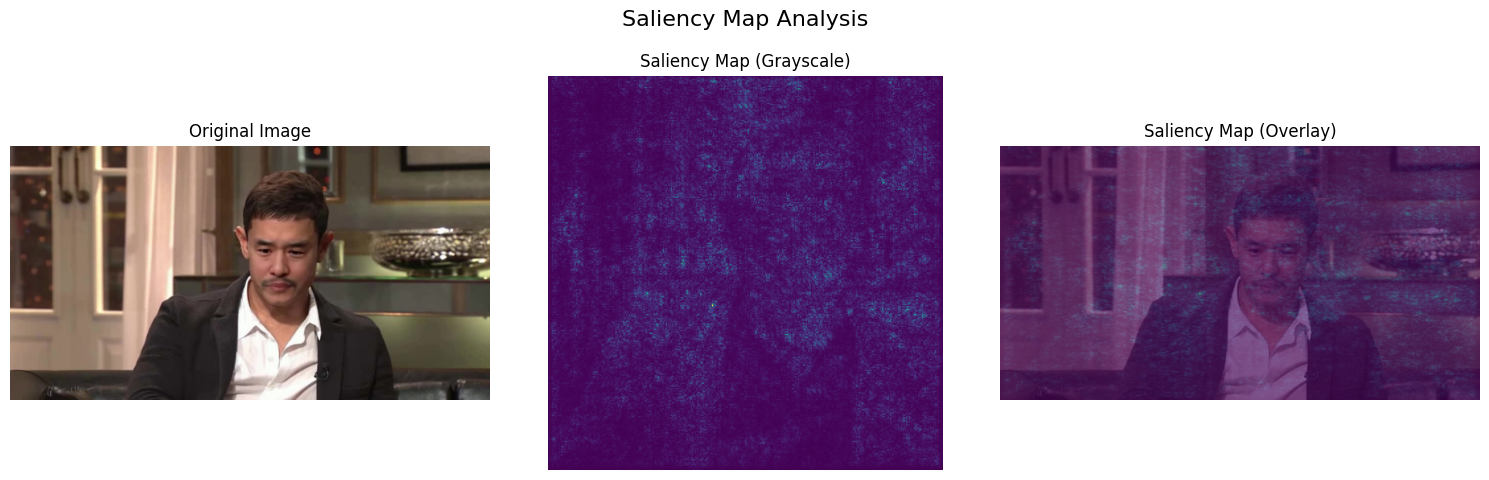

  > Saved Saliency Map Overlay to xai_outputs_xception_vl_custom_fast/saliency_map_overlay.png
  > Saved Saliency Map Grayscale to xai_outputs_xception_vl_custom_fast/saliency_map_grayscale.png

--- Running Guided Backpropagation ---


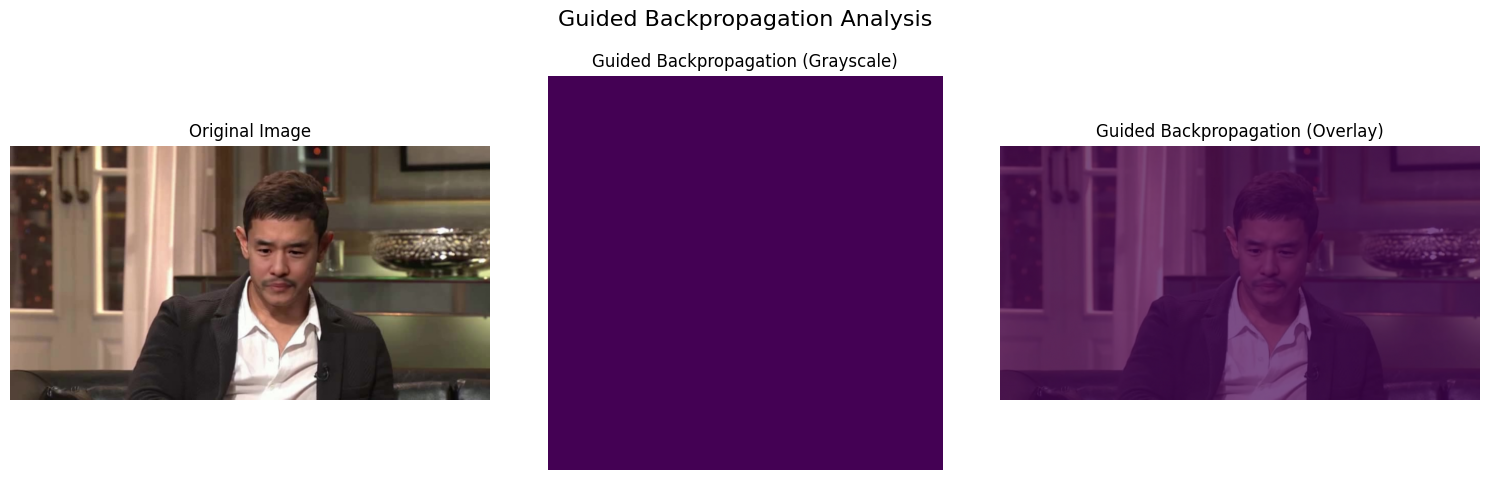

  > Saved Guided Backprop Overlay to xai_outputs_xception_vl_custom_fast/guided_backprop_overlay.png
  > Saved Guided Backprop Grayscale to xai_outputs_xception_vl_custom_fast/guided_backprop_grayscale.png

--- Running Grad-CAM and Activation Maps (Target Layer: SeparableConv2d) ---


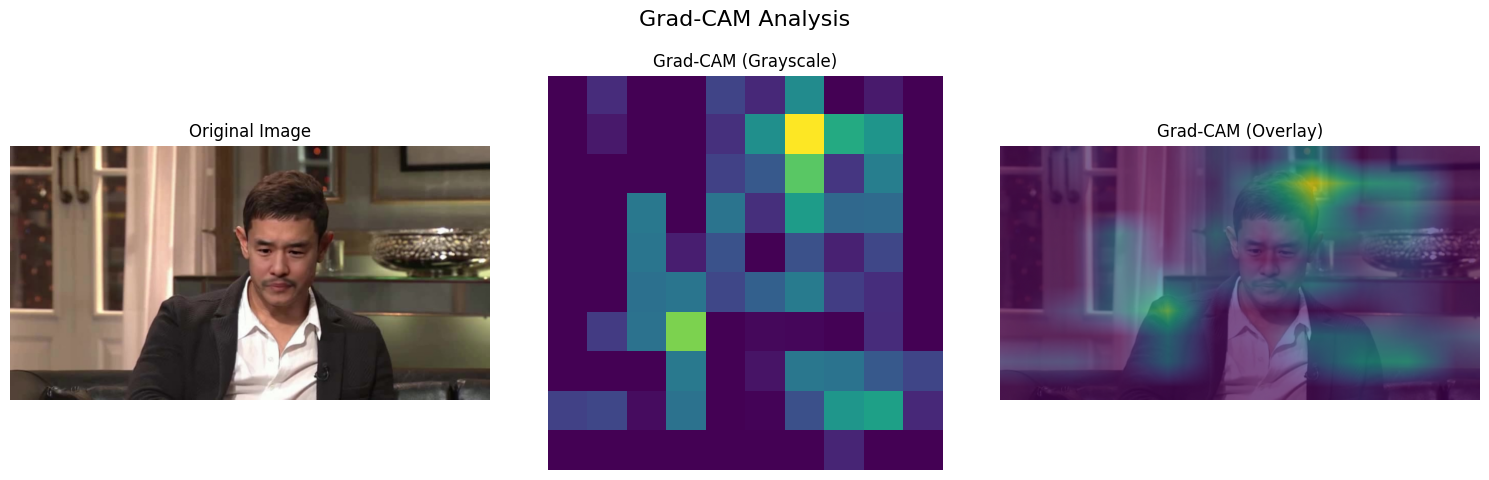

  > Saved Grad-CAM Overlay to xai_outputs_xception_vl_custom_fast/grad_cam_overlay.png
  > Saved Grad-CAM Grayscale to xai_outputs_xception_vl_custom_fast/grad_cam_grayscale.png
Saving top 8 activation maps from layer SeparableConv2d...


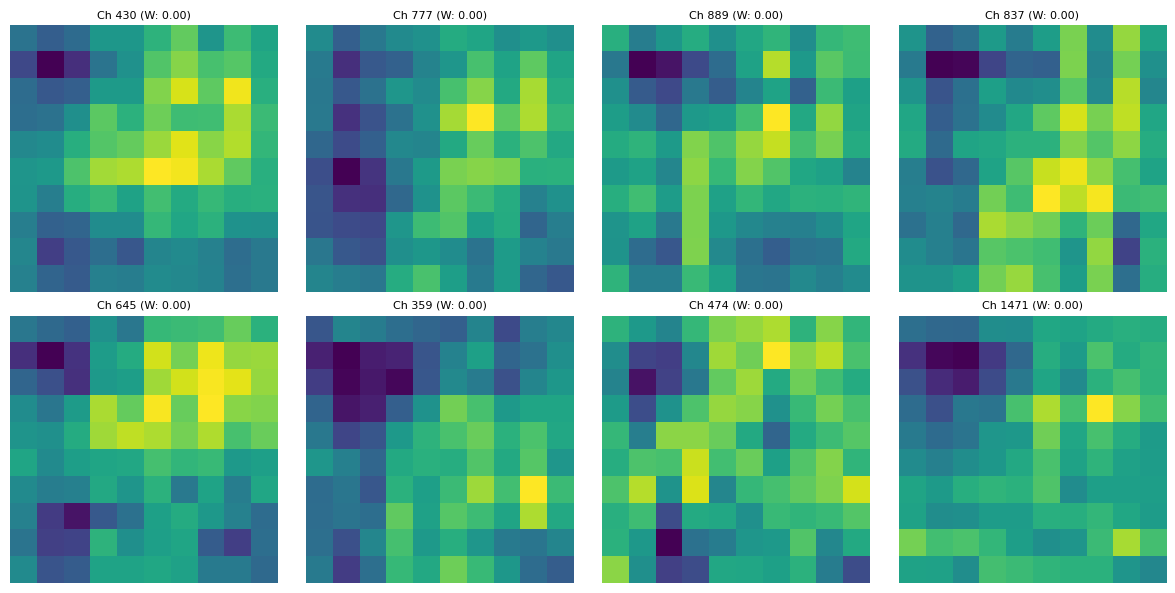

  > Saved Top 8 Activation Maps to xai_outputs_xception_vl_custom_fast/top_activation_maps.png

--- Running Concept-Level Visualization (Zero-Shot CLIP Grounding) ---
Top 3 Most Grounded Concepts:
  1. perfectly natural and realistic: 40.10%
  2. asymmetrical or distorted features: 32.65%
  3. sharp edges that look pasted on: 11.95%


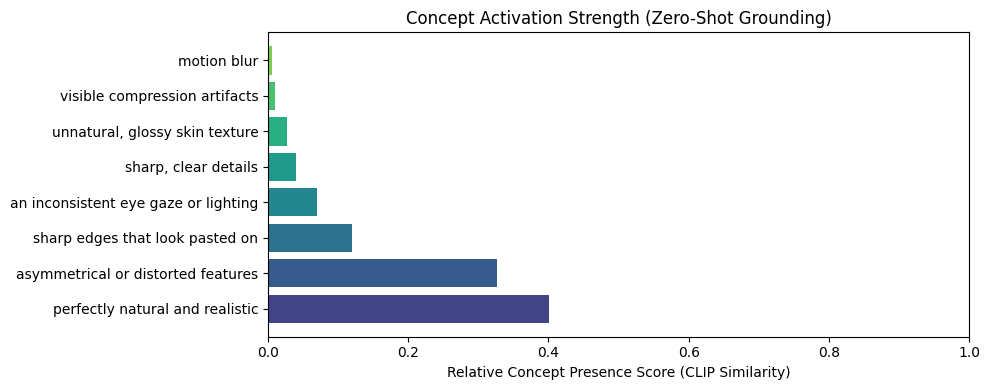


-------------------------------------------
XAI analysis pipeline complete.
All images saved to the 'xai_outputs_xception_vl_custom_fast' directory.


In [15]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
import gc
# NOTE: Using 'from torchvision import ...' only for transforms now
from torchvision import transforms
from PIL import Image

# --- VISION-LANGUAGE IMPORTS (Fast BLIP/CLIP) ---
try:
    from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel
except ImportError:
    print("Warning: 'transformers' library not found. Vision-Language analysis will be skipped.")
    BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel = [None] * 4

# --- XCEPTION (TIMM) IMPORT ---
try:
    import timm
except ImportError:
    print("Warning: 'timm' library not found. Xception model loading will fail.")
    timm = None

# --- CONFIGURATION ---
# IMPORTANT: Update this path to your input image file
IMAGE_PATH = "/content/drive/MyDrive/celeba_models/frame_0006.jpg"

# IMPORTANT: SET THIS TO THE PATH OF YOUR CUSTOM XCEPTION CHECKPOINT
XCEPTION_CHECKPOINT_PATH = "/content/drive/MyDrive/celeba_models/xception_quick.pt"

OUTPUT_DIR = "xai_outputs_xception_vl_custom_fast"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Mapping the 0/1 index to your classification labels (update as needed)
# Assuming 0: Real, 1: Fake/Manipulated
CLASS_LABELS = ["Real Image", "Fake/Manipulated Image"]

# Concepts for Zero-Shot Concept Grounding (CLIP)
CONCEPT_PROMPTS = [
    "A face with sharp, clear details",
    "A face with motion blur",
    "A face with unnatural, glossy skin texture",
    "A face with asymmetrical or distorted features",
    "A face with visible compression artifacts",
    "A face that looks perfectly natural and realistic",
    "A face with sharp edges that look pasted on",
    "A face with an inconsistent eye gaze or lighting"
]
# ---------------------

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print(f"Running on device: {DEVICE}")

# --- UTILITY FUNCTIONS ---

def normalize_numpy_array(arr):
    """Normalizes a NumPy array to the 0-1 range."""
    arr_min = arr.min()
    arr_max = arr.max()
    if arr_max == arr_min:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

def save_img(img_array, title, filename):
    """Saves a NumPy array (assumed 0-1 range) as an image file."""
    filepath = os.path.join(OUTPUT_DIR, filename)
    plt.imsave(filepath, img_array)
    print(f"  > Saved {title} to {filepath}")

def create_overlay(original_img, heatmap, alpha=0.6):
    """Creates a heatmap overlay on the original image using a color map."""
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Apply a color map
    heatmap_colored = plt.get_cmap('viridis')(heatmap_resized)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)

    original_img_uint8 = (original_img * 255).astype(np.uint8)

    # Simple image blending
    overlay = cv2.addWeighted(original_img_uint8, 1 - alpha, heatmap_colored, alpha, 0)

    return overlay / 255.0

def visualize_xai_map(original_img, xai_map_normalized, xai_overlay, map_name):
    """Creates a 3-panel figure and displays it inline."""
    # 1. Create the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{map_name} Analysis", fontsize=16)

    # 2. Original Image
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 3. Grayscale Map
    # Use 'viridis' colormap for clear visualization of importance
    axes[1].imshow(xai_map_normalized, cmap='viridis')
    axes[1].set_title(f"{map_name} (Grayscale)")
    axes[1].axis('off')

    # 4. Overlay
    axes[2].imshow(xai_overlay)
    axes[2].set_title(f"{map_name} (Overlay)")
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # KEY: This displays the plot inline
    plt.close(fig) # Close the figure to free memory

# --- VISION-LANGUAGE ANALYSIS (FAST BLIP/CLIP) ---

def run_vision_language_analysis(img_path, device):
    """
    Generates a descriptive caption (BLIP-Base) and runs an image-to-text
    matching (CLIP) against specific prompts.
    """
    if BlipProcessor is None:
        print("\nSkipping Vision-Language analysis: 'transformers' library is not available.")
        return "BLIP/CLIP skipped.", "BLIP/CLIP skipped."

    print("\n--- Running Vision-Language Analysis (BLIP-Base & CLIP) ---")

    try:
        # Load models (BLIP-Base and CLIP-Base are much faster to load)
        blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device).eval()
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
        clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        # Load image (PIL format needed for processor)
        img = Image.open(img_path).convert('RGB')

        with torch.no_grad(): # <-- FIX: Ensure no gradients are tracked for VLM inference
            # 1. BLIP Captioning
            inputs = blip_processor(images=img, return_tensors="pt").to(device)
            caption_ids = blip_model.generate(**inputs, max_new_tokens=40)
            description = blip_processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

            print(f"BLIP Description (Semantic): \"{description}\"")

            # 2. CLIP Matching against simple artifacts
            text_prompts = [
                "a real human face photo",
                "a fake or AI-generated face",
                "eyes look asymmetric",
                "skin has inconsistent texture",
            ]

            tokens = clip_preprocess(text=text_prompts, images=img, return_tensors="pt", padding=True).to(device)
            outputs = clip_model(**tokens)

            # Calculate probabilities
            probs = outputs.logits_per_image.softmax(dim=1).squeeze().cpu().tolist()
            best_match_index = np.argmax(probs)
            best_match_text = text_prompts[best_match_index]
            best_match_score = probs[best_match_index] * 100

            print(f"CLIP Best Match (Simple Artifact Feature): \"{best_match_text}\" (Confidence: {best_match_score:.2f}%)")

        return description, best_match_text

    except Exception as e:
        print(f"ERROR: Could not run VLM analysis. Error details: {e}")
        return "BLIP/CLIP failed.", "CLIP failed."
    finally:
        # Clean up VLM memory
        try:
            del blip_processor, blip_model, clip_model, clip_preprocess
        except:
            pass
        torch.cuda.empty_cache()
        gc.collect()

def run_concept_grounding(img_path, device, concept_prompts):
    """
    Uses CLIP to calculate the similarity of the image to a set of abstract
    concepts and visualizes the scores.
    """
    if CLIPModel is None:
        print("\nSkipping Concept Grounding: 'transformers' library is not available.")
        return

    print("\n--- Running Concept-Level Visualization (Zero-Shot CLIP Grounding) ---")

    try:
        # Load the smaller, faster CLIP model again
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
        clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        img = Image.open(img_path).convert('RGB')

        # Process inputs
        tokens = clip_preprocess(text=concept_prompts, images=img, return_tensors="pt", padding=True).to(device)

        with torch.no_grad(): # <-- FIX: Ensure no gradients are tracked for VLM inference
            # Run model
            outputs = clip_model(**tokens)

            # Calculate probabilities (similarity scores)
            # We use softmax over the scores to normalize them and treat them as
            # probabilities (or relative strengths of presence).
            probs = outputs.logits_per_image.softmax(dim=1).squeeze().cpu().numpy()

        # Format results
        # Normalize the scores to sum to 1 only if there are multiple concepts
        if probs.ndim == 0: # Handle case with only one concept (unlikely here)
            results = [(concept_prompts[0], probs.item())]
        else:
            results = sorted(zip(concept_prompts, probs), key=lambda x: x[1], reverse=True)

        top_concepts = [(r[0].replace("A face with ", "").replace("A face that looks ", ""), r[1]) for r in results]

        print("Top 3 Most Grounded Concepts:")
        for i, (concept, score) in enumerate(top_concepts[:3]):
            print(f"  {i+1}. {concept}: {score * 100:.2f}%")

        # Visualization (Bar Chart)
        fig, ax = plt.subplots(figsize=(10, len(concept_prompts) * 0.5))

        concepts = [r[0] for r in top_concepts]
        scores = [r[1] for r in top_concepts]

        # Use a colormap for visual appeal on the bar chart
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(concepts)))
        ax.barh(concepts, scores, color=colors)
        ax.set_xlabel("Relative Concept Presence Score (CLIP Similarity)")
        ax.set_title("Concept Activation Strength (Zero-Shot Grounding)")
        ax.set_xlim(0, 1)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

    except Exception as e:
        print(f"ERROR: Could not run Concept Grounding. Error details: {e}")
    finally:
        try:
            del clip_model, clip_preprocess
        except:
            pass
        torch.cuda.empty_cache()
        gc.collect()


# --- XCEPTION XAI CORE FUNCTIONS ---

def load_model_and_preprocess(img_path, checkpoint_path):
    """
    Loads the Xception model architecture using timm, loads custom weights,
    and preprocesses the image.

    Returns: model, original_img (np array), input_tensor, target_layer (for Grad-CAM)
    """
    if timm is None:
        raise ImportError("The 'timm' library is required to load Xception but was not found.")

    print("Loading Xception model architecture using timm...")

    # 1. Initialize the Xception model architecture using timm
    model = timm.create_model("xception", pretrained=False, num_classes=2)

    # 2. Load the custom checkpoint weights
    print(f"Loading custom weights from: {checkpoint_path}")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Custom model checkpoint not found at: {checkpoint_path}")

    state_dict = torch.load(checkpoint_path, map_location=DEVICE)

    # Try to unpack the state dictionary if it's nested
    if 'model' in state_dict:
        state_dict = state_dict['model']

    # Load the weights into the model
    model.load_state_dict(state_dict, strict=False)

    print("Custom Xception model loaded successfully.")

    model.eval()
    model.to(DEVICE)

    # Define the preprocessing steps for Xception (expected 299x299 input)
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        # Standard ImageNet normalization for Xception
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path).convert('RGB')

    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    original_img = np.array(img).astype(np.float32) / 255.0

    # Target layer for Grad-CAM: The final convolutional layer (conv3)
    target_layer = model.conv3

    return model, original_img, input_tensor, target_layer

def run_saliency_map(model, input_tensor, original_img):
    """Calculates, saves, and visualizes the Saliency Map."""
    print("\n--- Running Saliency Map ---")

    input_tensor.requires_grad_()
    output = model(input_tensor)
    pred_index = output.argmax(dim=1).item()

    model.zero_grad()
    score = output[0, pred_index]
    score.backward()

    gradients = input_tensor.grad.data.abs().squeeze().cpu().numpy()
    saliency = np.sum(gradients, axis=0)

    normalized_saliency = normalize_numpy_array(saliency)
    saliency_overlay = create_overlay(original_img, normalized_saliency, alpha=0.7)

    # Display and Save
    visualize_xai_map(original_img, normalized_saliency, saliency_overlay, "Saliency Map")
    save_img(saliency_overlay, "Saliency Map Overlay", "saliency_map_overlay.png")
    save_img(normalized_saliency, "Saliency Map Grayscale", "saliency_map_grayscale.png")


def run_guided_backprop(model, input_tensor, original_img):
    """Calculates, saves, and visualizes the Guided Backpropagation map."""
    print("\n--- Running Guided Backpropagation ---")

    # ReLU modifier for Guided Backprop
    def guided_relu_hook(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0) * torch.clamp(grad_out[0], min=0)),

    # Register the hook on ALL ReLU layers
    relu_handlers = []
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            handler = module.register_backward_hook(guided_relu_hook)
            relu_handlers.append(handler)

    input_tensor.requires_grad_()
    output = model(input_tensor)
    pred_index = output.argmax(dim=1).item()

    model.zero_grad()
    score = output[0, pred_index]
    score.backward()

    guided_gradients = input_tensor.grad.data.cpu().numpy()[0]
    guided_backprop_map = np.sum(np.abs(guided_gradients), axis=0)

    normalized_gbp = normalize_numpy_array(guided_backprop_map)
    gbp_overlay = create_overlay(original_img, normalized_gbp, alpha=0.7)

    # Clean up hooks
    for handler in relu_handlers:
        handler.remove()

    # Display and Save
    visualize_xai_map(original_img, normalized_gbp, gbp_overlay, "Guided Backpropagation")
    save_img(gbp_overlay, "Guided Backprop Overlay", "guided_backprop_overlay.png")
    save_img(normalized_gbp, "Guided Backprop Grayscale", "guided_backprop_grayscale.png")


def run_grad_cam_and_activation_maps(model, input_tensor, original_img, target_layer):
    """Calculates, saves, and visualizes Grad-CAM and saves the top activation maps."""
    print(f"\n--- Running Grad-CAM and Activation Maps (Target Layer: {target_layer.__class__.__name__}) ---")

    feature_maps = {}
    gradients = {}

    def save_features(module, input, output):
        feature_maps['features'] = output.data

    def save_gradients(module, grad_in, grad_out):
        gradients['gradients'] = grad_out[0].data

    hook_handle_fwd = target_layer.register_forward_hook(save_features)
    hook_handle_bwd = target_layer.register_full_backward_hook(save_gradients)

    # Forward Pass and Prediction
    output = model(input_tensor)
    pred_index = output.argmax(dim=1).item()

    # Backward Pass (Grad-CAM Calculation)
    model.zero_grad()
    score = output[0, pred_index]
    score.backward(retain_graph=True)

    # Compute Grad-CAM
    features = feature_maps['features'].squeeze().cpu().numpy()
    grads = gradients['gradients'].squeeze().cpu().numpy()
    weights = np.mean(grads, axis=(1, 2))

    cam = np.zeros(features.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * features[i, :, :]

    cam = np.maximum(cam, 0)

    normalized_cam = normalize_numpy_array(cam)
    cam_overlay = create_overlay(original_img, normalized_cam, alpha=0.7)

    # Display and Save Grad-CAM results
    visualize_xai_map(original_img, normalized_cam, cam_overlay, "Grad-CAM")
    save_img(cam_overlay, "Grad-CAM Overlay", "grad_cam_overlay.png")
    save_img(normalized_cam, "Grad-CAM Grayscale", "grad_cam_grayscale.png")

    # Save Activation Maps (Bonus Visualization)
    top_channels_indices = np.argsort(weights)[::-1][:8]
    print(f"Saving top 8 activation maps from layer {target_layer.__class__.__name__}...")

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i, idx in enumerate(top_channels_indices):
        activation_map = features[idx]
        normalized_activation = normalize_numpy_array(activation_map)

        axes[i].imshow(normalized_activation, cmap='viridis')
        axes[i].set_title(f"Ch {idx} (W: {weights[idx]:.2f})", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "top_activation_maps.png"))
    plt.show() # Display activation maps inline
    plt.close(fig)
    print(f"  > Saved Top 8 Activation Maps to {os.path.join(OUTPUT_DIR, 'top_activation_maps.png')}")

    # Clean up hooks
    hook_handle_fwd.remove()
    hook_handle_bwd.remove()


# --- MAIN EXECUTION BLOCK ---

if __name__ == "__main__":
    print(f"Starting Xception (Custom Weights) + Vision-Language XAI analysis pipeline.")
    print(f"Using image: {IMAGE_PATH}")
    print(f"Using Xception checkpoint: {XCEPTION_CHECKPOINT_PATH}")
    print(f"Outputting results to directory: {OUTPUT_DIR}")

    # 1. Vision-Language Analysis (High-Level Semantic Check)
    blip_caption, clip_match = run_vision_language_analysis(IMAGE_PATH, DEVICE)

    # 2. Load Xception model and preprocess image
    try:
        model, original_img, input_tensor, target_layer = load_model_and_preprocess(
            img_path=IMAGE_PATH,
            checkpoint_path=XCEPTION_CHECKPOINT_PATH
        )

    except (FileNotFoundError, ImportError) as e:
        print(f"FATAL ERROR: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred during model loading or preprocessing: {e}")
        sys.exit(1)

    # 3. Get Model Prediction and Display it prominently in console
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()
        pred_index = np.argmax(probabilities)
        pred_label = CLASS_LABELS[pred_index]
        pred_prob = probabilities[pred_index] * 100

    print("\n===========================================")
    print(f"✅ MODEL PREDICTION (Xception): {pred_label}")
    print(f"   Confidence: {pred_prob:.2f}%")
    print("===========================================")

    # 4. Run XAI Techniques (Saves to file AND Displays Inline)

    # Saliency Map (Pixel Importance)
    # Cloning the tensor and requiring grad for saliency/backprop is necessary
    run_saliency_map(model, input_tensor.clone(), original_img)

    # Guided Backpropagation (Finer-grained Pixel Importance)
    run_guided_backprop(model, input_tensor.clone(), original_img)

    # Grad-CAM and Activation Maps (Feature Importance)
    run_grad_cam_and_activation_maps(
        model,
        input_tensor.clone(),
        original_img,
        target_layer
    )

    # 5. Concept Grounding (New Concept-Level Visualization)
    run_concept_grounding(
        img_path=IMAGE_PATH,
        device=DEVICE,
        concept_prompts=CONCEPT_PROMPTS
    )

    print("\n-------------------------------------------")
    print("XAI analysis pipeline complete.")
    print(f"All images saved to the '{OUTPUT_DIR}' directory.")

    # Clean up memory
    del model, input_tensor, original_img
    torch.cuda.empty_cache()
    gc.collect()
